In [2]:
%cd ../..

/Users/stefanomartire/GitHub/OBIWAN_main


In [3]:
from results.MD import MD_utils
from results.MD import MD_engine
from architectures import net_utils
import tensorflow as tf

In [4]:
import matplotlib.pyplot as plt
import numpy as np

## MD settings

In [4]:
chosen_dtype = 'float32'
tf.keras.backend.set_floatx(chosen_dtype)
tf.keras.mixed_precision.set_global_policy(chosen_dtype)

settings = MD_utils.Settings()
settings.dt = 0.001    # time step [ps]
settings.seed = 777
settings.int_type = 'vv_gromacs'
settings.strideSaving = 10        # every strideSaving steps we save the chosen properties

input_file = "results/MD/inputs/K3T/K3T_angle.sdf"

# settings.pdbFileName = "results/MD/mdTraj.pdb"
settings.xyzFileName = "results/MD/outputs/K3T_angle_traj_1fs.xyz"
save_forces = True
settings.forcesFileName = "results/MD/outputs/K3T_angle_traj_1fs.forces"

## System settings

Inputs must be in **Angstrom**

In [5]:
numberAtoms, coords, types, masses = MD_utils.readSDFile(input_file)    # in Angstrom
box_sizes = tf.constant([1000.0,1000.0,1000.0], dtype=chosen_dtype)     # in Angstrom

coords = tf.cast(coords/10.0, dtype=chosen_dtype)           # convert Angstrom to nm for the MD
box_sizes = tf.cast(box_sizes/10.0, dtype=chosen_dtype)
masses = tf.expand_dims(masses, axis=-1)
masses = tf.tile(masses, [1, 3])
masses = tf.cast(masses, dtype=chosen_dtype)

# NNP

In [6]:
obiwan = net_utils.getModel(
                    model_name="obiwan",
                    dynamic_mode=True,
                    weights="results/models/obiwan_ani1Uani2_FH_VL_2.404",
                )

In [7]:
@tf.function
def energy_tf(coordinates, box_sizes, species):
    # Convert nm to Angstrom for Obiwan
    coordinates = coordinates * 10.
    box_sizes = box_sizes * 10.
    # Add batch dimension
    coordinates = tf.expand_dims(coordinates, axis=0)
    species = tf.expand_dims(species, axis=0)
    box_sizes = tf.expand_dims(box_sizes, axis=0)
    # Compute energy and remove batch dimension
    energy = obiwan([coordinates, species, box_sizes])
    energy = tf.squeeze(energy)
    # Convert Ha to kJ/mol for saving
    energy = energy * 2625.5
    return energy

# Setup and run

In [8]:
sys = MD_utils.System(chosen_dtype)
sys.getNNSys(numberAtoms, box_sizes, masses, coords, energy_tf, types)
md = MD_engine.MolecularDynamics(settings, sys, chosen_dtype, wrapping=False, save_forces=save_forces)

md.initState()

<<INFO>> VV gamma 0.500000 ps^-1


In [9]:
eta = 1e-6
maxIt = 1_000_000
stopCond = ["max_force", 0.7]      # the real condition
md.minimize(eta, stopCond, maxIt)

<<INFO>> Minimization: It 0 Potential value -5258797.0 max force value 2048.158935546875
<<INFO>> Minimization: It 1000 Potential value -5258827.0 max force value 8.045461654663086
<<INFO>> Minimization: It 2000 Potential value -5258828.0 max force value 6.201496124267578
<<INFO>> Minimization: It 3000 Potential value -5258828.0 max force value 5.365228652954102
<<INFO>> Minimization: It 4000 Potential value -5258828.5 max force value 4.993391036987305
<<INFO>> Minimization: It 5000 Potential value -5258828.5 max force value 4.45892333984375
<<INFO>> Minimization: It 6000 Potential value -5258828.5 max force value 3.8403701782226562
<<INFO>> Minimization: It 7000 Potential value -5258829.0 max force value 3.2628440856933594
<<INFO>> Minimization: It 8000 Potential value -5258829.5 max force value 2.7602195739746094
<<INFO>> Minimization: It 9000 Potential value -5258829.5 max force value 2.350444793701172
<<INFO>> Minimization: It 10000 Potential value -5258829.0 max force value 2.0068

In [10]:
md.settings.T = tf.constant(100.0, dtype=chosen_dtype)
numSteps = 1_000            # 1 ps
md.run(numSteps)

md.settings.T = tf.constant(200.0, dtype=chosen_dtype)
md.run(numSteps, append_results=True)

md.settings.T = tf.constant(300.0, dtype=chosen_dtype)
numSteps = 1_000_000        # 1 ns
md.run(numSteps, append_results=True)

<<INFO>> Total sim time: 0.001 ns
<<INFO>> Time step: 0.001 ps
<<INFO>> Start looping..


100%|██████████| 1000/1000 [00:16<00:00, 60.77it/s]


<<INFO>> Performing 5.29 ns/day
<<INFO>> Total sim time: 0.001 ns
<<INFO>> Time step: 0.001 ps
<<INFO>> Start looping..


100%|██████████| 1000/1000 [00:16<00:00, 60.43it/s]


<<INFO>> Performing 5.26 ns/day
<<INFO>> Total sim time: 1.0 ns
<<INFO>> Time step: 0.001 ps
<<INFO>> Start looping..


100%|██████████| 1000000/1000000 [4:42:26<00:00, 59.01it/s] 

<<INFO>> Performing 5.10 ns/day


# Visualization

## Energy

In [16]:
xyz, typ, Na, energies = MD_utils.readXYZ("results/MD/outputs/K3T_angle_traj_1fs.xyz")

In [17]:
energies = np.array(energies, dtype=np.float32)
energies = energies[200:]   # remove temperature equilibration

In [18]:
energies = energies[-2500:]     # last 25 ps (we saved every 10 steps)

steps = np.arange(0, len(energies), dtype=np.float32)
steps /= 100    # convert to ps

In [19]:
energies = energies - np.mean(energies)     # center around 0
energies /= 4.184       # convert to kcal/mol

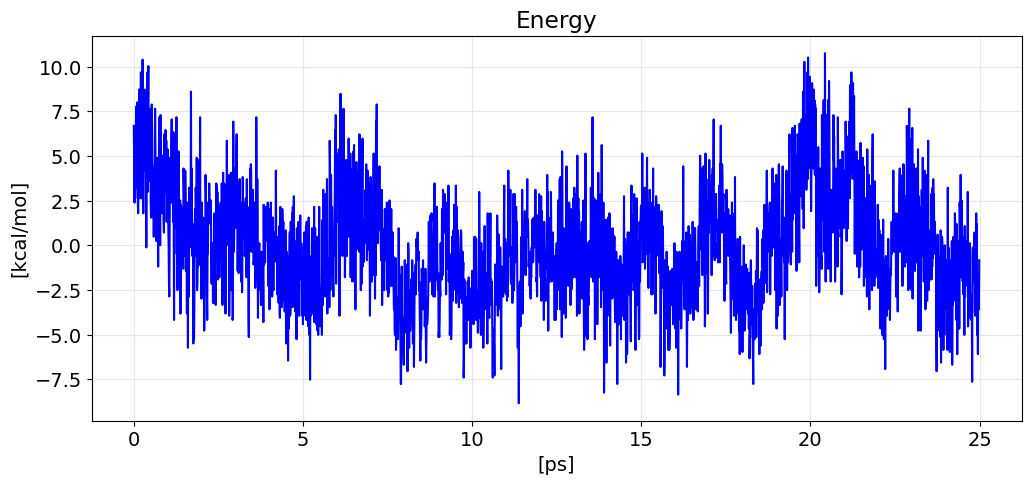

In [20]:
# set the size of all the fonts to 14
plt.rc('font', size=14)

plt.plot(steps, energies, color='blue')
plt.xlabel("[ps]")
plt.ylabel("[kcal/mol]")
plt.title("Energy")

plt.grid(color='0.9')

fig = plt.gcf()
fig.set_size_inches(12, 5)

## Forces

In [28]:
forces, typ, Na, energies = MD_utils.readXYZ("results/MD/outputs/K3T_angle_traj_1fs.forces")

In [29]:
forces = np.array(forces, dtype=np.float32)

In [30]:
# forces has shape (numSteps, numberAtoms, 3). compute the norm of the forces
forces = np.linalg.norm(forces, axis=-1)
# average over the atoms
forces = np.mean(forces, axis=-1)

forces = forces[200:]   # remove temperature equilibration

forces = forces[-2500:]     # last 25 ps (we saved every 10 steps)

steps = np.arange(0, len(forces), dtype=np.float32)
steps /= 100    # convert to ps

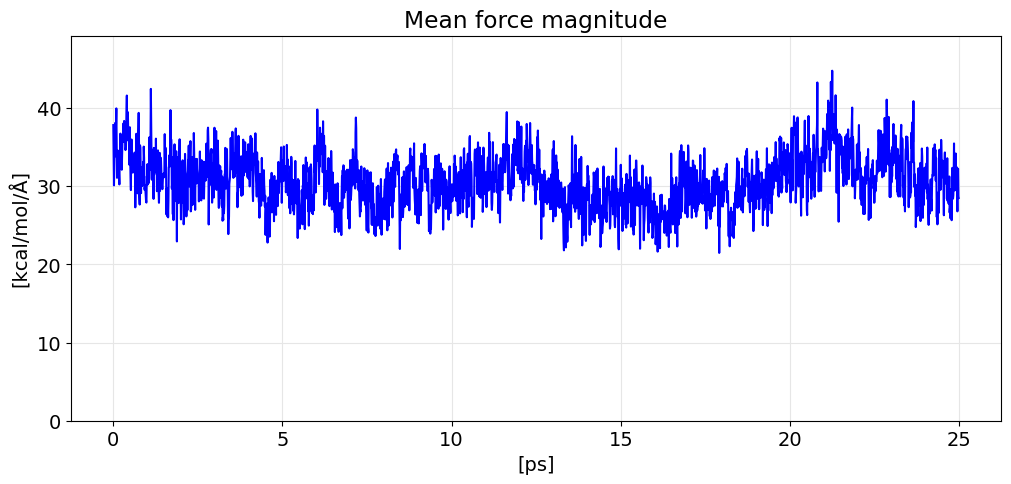

In [31]:
# set the size of all the fonts to 14
plt.rc('font', size=14)

plt.plot(steps, forces, color='blue')
plt.xlabel("[ps]")
plt.ylabel("[kcal/mol/Å]")
plt.title("Mean force magnitude")

plt.ylim(0, np.max(forces)*1.1)

plt.grid(color='0.9')

fig = plt.gcf()
fig.set_size_inches(12, 5)